# ASTR 496: Foundations of Data Science in Astronomy
# Fitting a Stellar Binary Orbit with MCMC using `emcee`
### Gautham Narayan

## Introduction

You are going to use Markov Chain Monte Carlo (MCMC) to fit the radial velocity curve of a binary star system. This is a fairly common problem in astrophysics where we observe the Doppler shift of spectral lines as stars orbit their common center of mass. You've already modeled a transit for an exoplanet light curve, so might as well model the other common method to find them.


I'll give you the physical setup - 

A binary star system with one visible component shows periodic radial velocity variations:

$$v_r(t) = K \sin\left(\frac{2\pi(t - t_0)}{P}\right) + v_0$$

where:
- $K$ = velocity semi-amplitude (km/s)
- $P$ = orbital period (days)
- $t_0$ = time of periastron passage (days)
- $v_0$ = systemic velocity (km/s)

In [91]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import stats
# import whatever else you want here

# Set random seed for reproducibility
np.random.seed(42) # the answer to Life, the Universe, Everything

# Plotting style
%matplotlib ipympl
%matplotlib inline

### Next, I'll create synthetic observations of a binary star system with known parameters, then add observational noise.

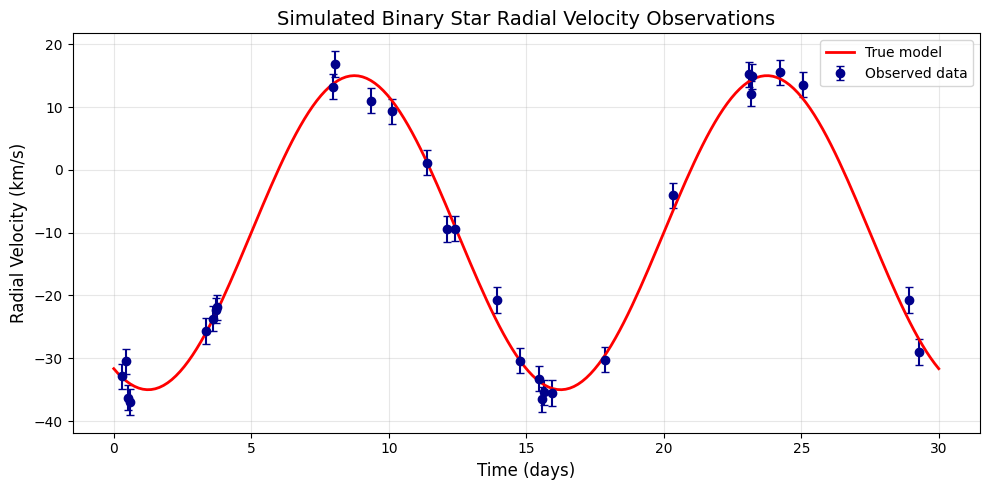

True parameters:
  K  = 25.0 km/s
  P  = 15.0 days
  t0 = 5.0 days
  v0 = -10.0 km/s


In [103]:
# True parameters (these are what we'll try to recover)
K_true = 25.0      # km/s
P_true = 15.0      # days
t0_true = 5.0      # days
v0_true = -10.0    # km/s

# Observation setup
n_obs = 30
t_obs = np.sort(np.random.uniform(0, 30, n_obs))  # Random times over 30 days
v_err = 2.0  # Measurement uncertainty (km/s)

# Model function
def radial_velocity_model(t, K, P, t0, v0):
    """Calculate radial velocity at time t for circular orbit"""
    phase = 2 * np.pi * (t - t0) / P
    return K * np.sin(phase) + v0

# Generate true signal
v_true = radial_velocity_model(t_obs, K_true, P_true, t0_true, v0_true)

# Add Gaussian noise
v_obs = v_true + np.random.normal(0, v_err, n_obs)

# Plot the data
plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
t_model = np.linspace(0, 30, 200)
v_model = radial_velocity_model(t_model, K_true, P_true, t0_true, v0_true)
plt.plot(t_model, v_model, 'r-', label='True model', linewidth=2)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Radial Velocity (km/s)', fontsize=12)
plt.title('Simulated Binary Star Radial Velocity Observations', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"True parameters:")
print(f"  K  = {K_true:.1f} km/s")
print(f"  P  = {P_true:.1f} days")
print(f"  t0 = {t0_true:.1f} days")
print(f"  v0 = {v0_true:.1f} km/s")

### OK now for the homework:

For MCMC, we need to define:
1. **Log-likelihood**: How well does a model fit the data?
2. **Log-prior**: What do we know before seeing the data?
3. **Log-posterior**: Combination of likelihood and prior (what we sample)

In [104]:
def log_likelihood(theta, t, v, v_err):
    """
    Calculate the log-likelihood of the model given the data.
    Remember
    theta : array
        Model parameters [K, P, t0, v0]
    t : array
        Observation times
    v : array
        Observed velocities
    v_err : float
        Measurement uncertainty
    """
    # you're doing this
    
    v_model = radial_velocity_model(t,theta[0],theta[1],theta[2],theta[3])
    res = v - v_model
    chisq = np.sum((res/v_err)**2)
    
    return -chisq/2 + np.sum(-np.log(v_err*np.sqrt(2*np.pi)))

def log_prior(theta):
    """
    Returns -inf if parameters are outside allowed ranges.
    """
    # [K, P, t0, v0]
    if 20 < theta[0] < 30 and 10 < theta[1] < 20 and 3 < theta[2] < 7 and -15 < theta[3] < -5:
        return -np.log(10*10*4*10)
    return -np.inf

def log_probability(theta, t, v, v_err):
    """
    Calculate the log-posterior probability.

    """
    return log_prior(theta) + log_likelihood(theta, t, v, v_err)

#### Justify the choice of prior in a few sentences

I analyzed the data without taking the true model into account and tried to find a range for all the parameters that made sense.

#### Describe how you treated the uncertainties in a few sentences

Since the v_err is constant for all points, the uncertainty is also a constant. I just plugged in v_err to the equation.

#### Next setup the MCMC. 

Use the affine-invariant ensemble sampler from `emcee`. This requires:
- Initial positions for multiple "walkers" (independent MCMC chains)
- Number of steps to run

**Rule of thumb**: Use at least 2×(number of parameters) walkers.

In [94]:
# MCMC setup
ndim = 4
nwalkers = 500
nsteps = 10000

# Set some initial positions for the walkers - I'd suggest adding small random scatter around a guess
# you can get your guess from scipy.optimize or just making something up.

guess = [22,11,4,-13] # just grabbing some numbers
sigmas = np.ones(4)
start_point = np.array(guess) + 0.1*sigmas*np.random.randn(nwalkers,ndim)


#### Run the MCMC Sampler
This may take a minute or two.

In [95]:
# Initialize the sampler
kwargs = {'t':t_obs, 'v':v_obs, 'v_err':v_err}
sampler = emcee.EnsembleSampler(nwalkers,ndim, log_probability, kwargs=kwargs)

# Run MCMC

state = sampler.run_mcmc(start_point,1000,progress=True)
sampler.reset()
sampler.run_mcmc(state,nsteps)


# Print the acceptance fraction from the sampler
print(np.mean(sampler.acceptance_fraction))

You must install the tqdm library to use progress indicators with emcee


0.5941628000000001


#### Analyze the Chains

i.e. heck if the chains have "converged" (reached the posterior distribution).
Do this by plotting the `nsteps` samples from all `nwalkers` chains 

**Key concepts:**

- **Autocorrelation time**: How many steps until samples are independent
- **Burn-in**: Initial steps where walkers move from initial positions to the posterior
- **Thinning**: take every n'th sample from the chains to reduce the autocorrelation


You can look at the slides for notes on this. Make some reasonable choices! Or if you don't have a good sense, you can use a burn-in that is twice the maximum autocorrelation time, and thinning of 1/2 the minimum autocorrelation time. This implies that there are multiple autocorrelation times, and you have to figure out how. 

[44.54253884 44.92406982 45.52283761 44.24339241]
91
22


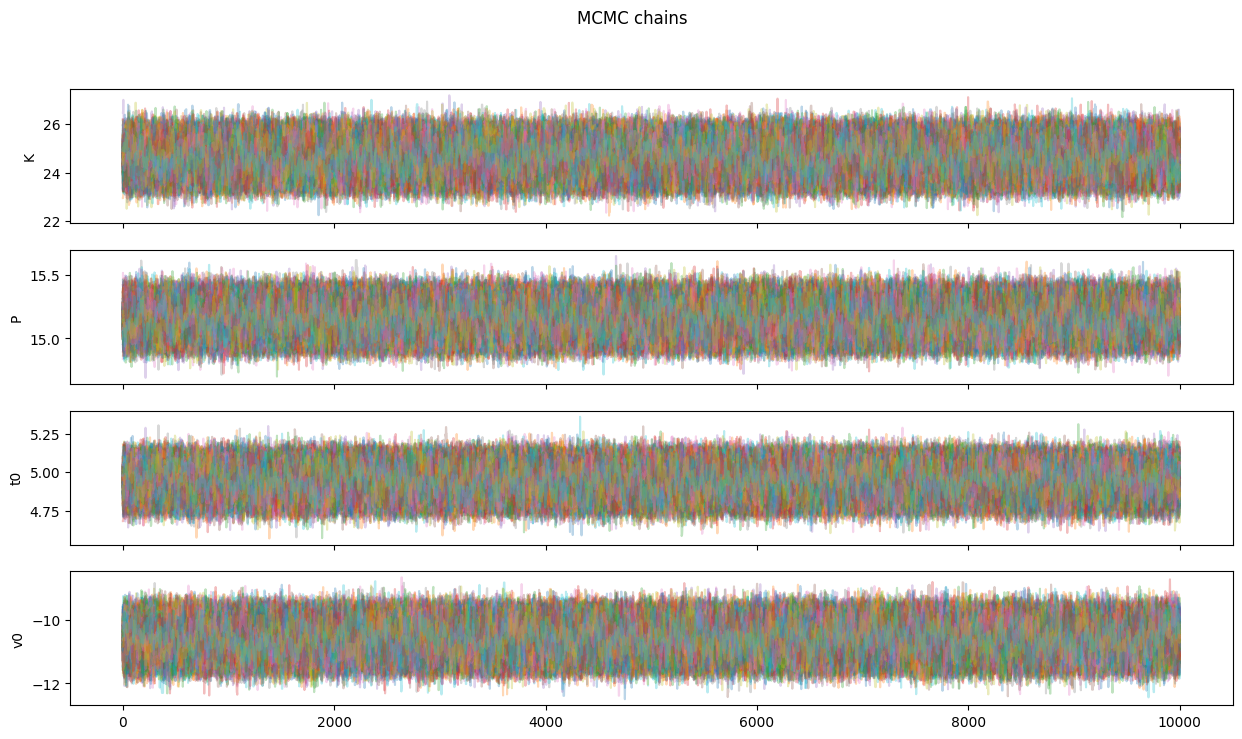

In [96]:
# Plot the chains - and remember to label your plots - you aren't silly first-years

samples = sampler.get_chain()

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(15, 8), sharex=True)

labels = ["K","P","t0","v0"]

fig.suptitle("MCMC chains")

for i in range(ndim):
    ax = axs[i]
    ax.plot(samples[:,:,i],alpha=0.3)
    ax.set_ylabel(labels[i])

# Calculate autocorrelation time
autotime = sampler.get_autocorr_time()
print(autotime)
burnin = int(2 * np.max(autotime))   
thin   = int(0.5 * np.min(autotime))
print(burnin)
print(thin)


#### Extract and Analyze Results

After discarding burn-in, you'll extract the posterior samples and calculate parameter estimates.

In [105]:
# Get flattened samples (discard burn-in and thin)
fsample = sampler.get_chain(discard=burnin, thin=thin, flat=True)

# Calculate parameter estimates
for i, name in enumerate(labels):
  percentile = np.percentile(fsample[:,i],[16,50,84])
  q = np.diff(percentile)
  print(f"{name}: {percentile[1]} (+{q[1]}, -{q[0]})")


K: 24.646179954332673 (+0.515853663872349, -0.5177480790269797)
P: 15.15643435298862 (+0.09743405264781835, -0.09701424845751205)
t0: 4.945552726608324 (+0.07536874898214396, -0.07607880696956304)
v0: -10.569600048330434 (+0.39726443102548714, -0.3978201087380686)


#### Create a Corner Plot

A corner plot shows all 1D and 2D marginalized distributions, revealing parameter correlations.

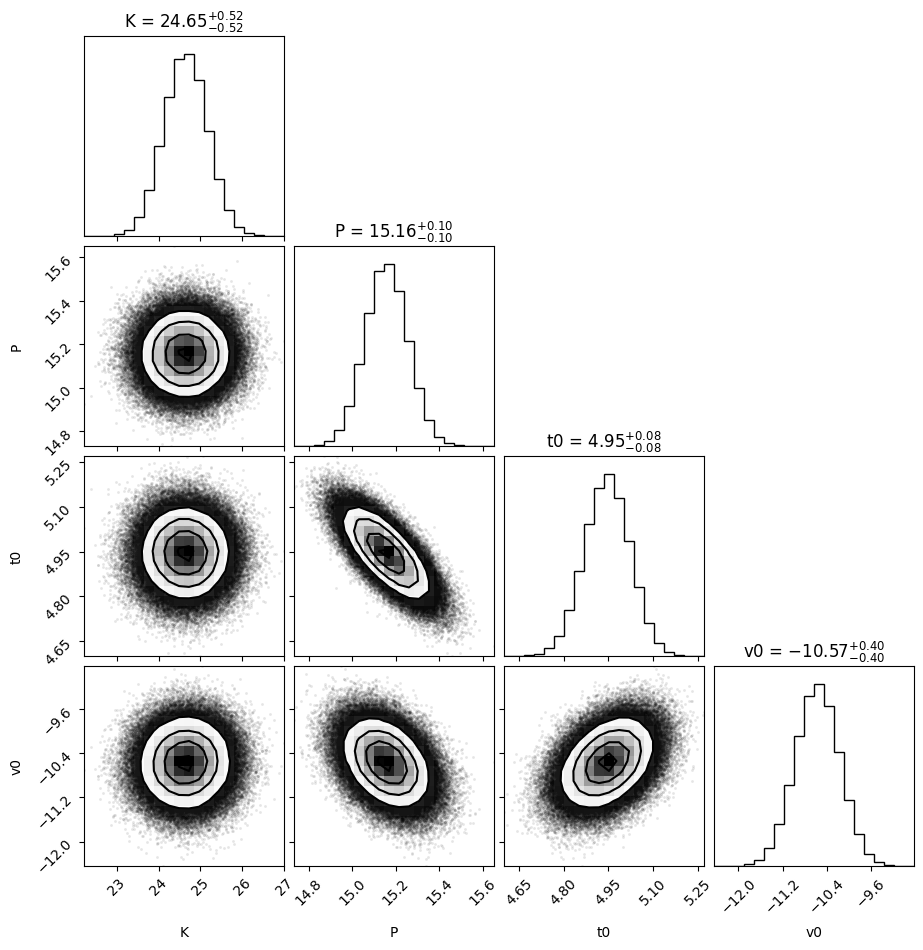

In [98]:
# you can use the corner package 
corner.corner(fsample, labels=labels, show_titles=True)
plt.show()

#### Plot the Best-Fit Model
LOOK AT YOUR DATA. Take the median estimate to be the "best-fit"
Plot some confidence interval

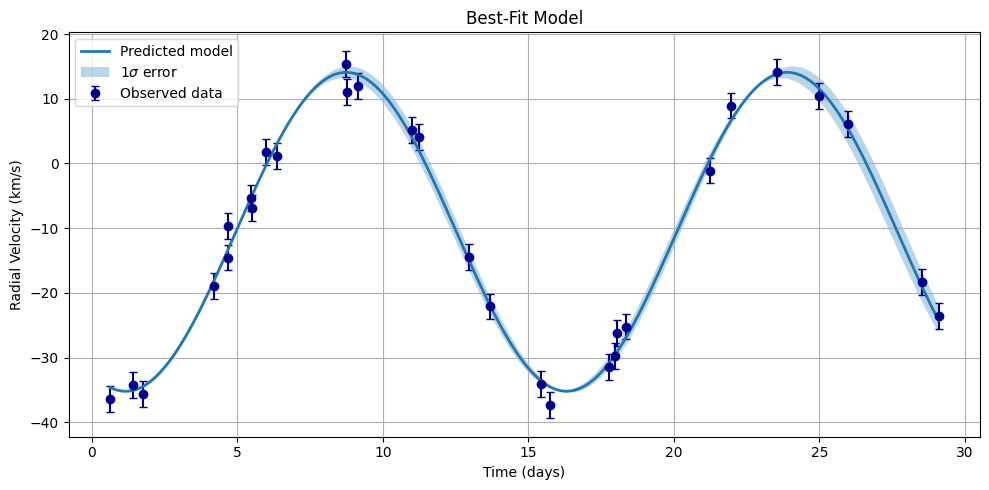

In [101]:
# also plot the true model - you can look at the simulation code
t_vals = np.linspace(min(t_obs), max(t_obs), 200)

mean = np.mean(fsample, axis=0)
lower  = np.percentile(fsample, 16, axis=0)
upper  = np.percentile(fsample, 84, axis=0)
lower_err = mean - lower
upper_err = upper - mean

v_mean = radial_velocity_model(t_vals, mean[0],mean[1],mean[2],mean[3])
v_lower = radial_velocity_model(t_vals, lower[0],lower[1],lower[2],lower[3])
v_upper = radial_velocity_model(t_vals, upper[0],upper[1],upper[2],upper[3])

plt.figure(figsize=(10, 5))
plt.errorbar(t_obs, v_obs, yerr=v_err, fmt='o', label='Observed data', 
             color='darkblue', markersize=6, capsize=3)
plt.plot(t_vals, v_mean, lw=2, label="Predicted model")
plt.fill_between(t_vals, v_lower, v_upper, alpha=0.3, label=r'1$\sigma$ error')    
plt.xlabel("Time (days)")
plt.ylabel("Radial Velocity (km/s)")
plt.title("Best-Fit Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Finally, again a few sentences here:

**Correlations**: Examine the corner plot. Are any parameters correlated? Why might K and v₀ show correlation?

P and t0 have a very strong correlation. v0 is also corellated with t0 and P. K and v0 don't seem to have correaltion. Hypothetically might have some corelation since higher K means the planet is of larger mass, swinging the star more, which can cause the entire system to move at a faster velocity.

**Uncertainty**: Compare the posterior uncertainties to the true values. Did our MCMC analysis recover the true parameters within the error bars?

No, P and v0 did not get recovered within the error bars.

**Sensitivity**: What happens if you increase the measurement uncertainty (`v_err`)? Try changing it to 10.0 km/s and rerun.

![alt text](output1.png)

The error is larger and the model is not fit as accurately

**Sampling**: What would happen if you used too few walkers (e.g., nwalkers=4)? Too few steps?

![alt text](output2.png)

If there are too few walkers and steps, there might not be enough walks explored to get a good prediction of the parameters. The MCMC might not even converge.

ANSWER GOES HERE - make a copy of the notebook if you need to, but just save the final plot you create above and discuss here
